In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[ke

In [2]:
from scipy.special import gamma, gammaln
import scipy.stats

In [3]:
import os, sys
import glob

In [4]:
import tqdm

In [5]:
from model import Norm

In [6]:
from volatility_detector import VolatilityDetector

In [7]:
def makedata(infiles_acc1, infiles_acc2,
             d_list, 
             idxes_start, idxes_end):
    d_f_a = pd.read_csv(infiles_acc1, header=None, index_col=0).reset_index(drop=True)
    d_f_a = d_f_a.loc[np.any(d_f_a != 0, axis=1), :]
    d_f_a.columns = ['acc_X', 'acc_Y', 'acc_Z']
    d_list.append(d_f_a)
    idxes_end.append(idxes_start[-1] + d_f_a.shape[0])
    idxes_start.append(idxes_end[-1] + 1)
    
    d_s_a = pd.read_csv(infiles_acc2, header=None, index_col=0)
    d_s_a = d_s_a.loc[np.any(d_s_a != 0, axis=1), :]
    d_s_a.columns = ['acc_X', 'acc_Y', 'acc_Z']
    d_s_a.dropna(inplace=True)
    
    d_list.append(d_s_a)
    idxes_end.append(idxes_start[-1] + d_s_a.shape[0])
    idxes_start.append(idxes_end[-1] + 1)

In [8]:
def detect_change_points_maxscore(scores):
    scores = np.array(scores)
    idxes_scores_positive = np.where(scores > 0)[0]
    
    idxes_end = np.where(
                              np.diff(idxes_scores_positive) > 1
                          )[0]
    end = idxes_scores_positive[idxes_end]

    idxes_start = idxes_end + 1  
    if 0 not in idxes_start:
        idxes_start = np.hstack((0, idxes_start))

    start = idxes_scores_positive[idxes_start]

    if idxes_scores_positive[idxes_start[1]-1] not in end:
        end = np.hstack((idxes_scores_positive[idxes_start[1] - 1], end))
    if idxes_scores_positive[-1] not in end:
        end = np.hstack((end, idxes_scores_positive[-1]))

    change_points = []
    for s, e in zip(start, end):
        cp = s + np.argmax(scores[s:e+1])
        change_points.append(cp)

    change_points = np.array(change_points)
    return change_points

In [9]:
def _getAplus(A):
    eigval, eigvec = np.linalg.eig(A)
    Q = np.matrix(eigvec)
    xdiag = np.matrix(np.diag(np.maximum(eigval, 0)))
    return Q*xdiag*Q.T

def _getPs(A, W=None):
    W05 = np.matrix(W**.5)
    return  W05.I * _getAplus(W05 * A * W05) * W05.I

def _getPu(A, W=None):
    Aret = np.array(A.copy())
    Aret[W > 0] = np.array(W)[W > 0]
    return np.matrix(Aret)

#def nearPD(A, nit=10):
def nearPD(A, nit=100):
    n = A.shape[0]
    W = np.identity(n) 
# W is the matrix used for the norm (assumed to be Identity matrix here)
# the algorithm should work for any diagonal W
    deltaS = 0
    Yk = A.copy()
    for k in range(nit):
        Rk = Yk - deltaS
        Xk = _getPs(Rk, W=W)
        deltaS = Xk - Rk
        Yk = _getPu(Xk, W=W)
    return Yk

In [10]:
def gammaln_m(x, m):
    """
    \gamma_{m}(x) = pi^(m(m-1)/4) * \prod_{j=1}^{m} \gamma(x + (1-j)/2)
    \log{\gamma_{m}(x)} = m(m-1)/4 * \log{\pi} + \sum_{j=1}^{m} \log{\gamma(x+(1-j)/2)}
    :param x:
    :param m:
    :return:
    """
    return m*(m-1)/4 * np.log(np.pi) + np.sum([gammaln(x + (1-j)/2) for j in range(1, m+1)])

def _log_NML_normalizer(k, m, mu_max, sigma_min):
        """
        Normalized Maximum Likelihood normalizer
        :param k:
        :param m:
        :param mu_max: maximum value of mu
        :param sigma_min: minimum value of sigma
        :return: log normalized maximum likelihood normalizer
        """
        return -(m+1)*np.log(m/2) + m/2*np.log(mu_max) - m**2/2*np.log(sigma_min) + \
               m*k/2.0*(np.log(k/2) - 1.0) - gammaln(m/2) - gammaln_m((k-1)/2, m)
               #m*k/2.0*(np.log(k/2) - 1.0) - gammaln(m/2) - gammaln((k-1)/2)

In [11]:
def calc_metachange_stats_v2(X, change_points, h=100, mu_max=2.0, sigma_min=0.005):
    metachange_stats = []
    
    
    #for t in range(h, len(X)-h):
    for i, cp in enumerate(change_points):
        mean1 = np.mean(X[(cp-h):cp, :], axis=0)
        cor1 = np.corrcoef(X[(cp-h):cp, :], rowvar=False)
        #mean2 = np.mean(X[cp:(cp+h+1), :].ravel())
        #std2 = np.std(X[cp:(cp+h+1), :].ravel())
        mean2 = np.mean(X[(cp+1):(cp+h+1), :], axis=0)
        cor2 = np.corrcoef(X[(cp+1):(cp+h+1), :], rowvar=False)

        if i == 0:
            mean1_prev, cor1_prev = mean1, cor1
            mean2_prev, cor2_prev = mean2, cor2
            continue

        metachange_up = np.mean(-scipy.stats.multivariate_normal(mean1 + (mean2_prev - mean1_prev), nearPD(cor1 + (cor2_prev - cor1_prev)), allow_singular=True).logpdf(X[(cp+1):(cp+h+1), :]))
        metachange_down = np.mean(-scipy.stats.multivariate_normal(mean1 - (mean2_prev - mean1_prev), nearPD(cor1 - (cor2_prev - cor1_prev)), allow_singular=True).logpdf(X[(cp+1):(cp+h+1), :]))

        d = X.shape[1]
        metachange = np.nanmin([metachange_up, metachange_down]) - ( _log_NML_normalizer(d + d*(d+1)/2, d, mu_max=mu_max, sigma_min=sigma_min) ) / h

        metachange_stats.append(metachange)
        #print(metachange)

        mean1_prev, cor1_prev = mean1, cor1
        mean2_prev, cor2_prev = mean2, cor2
    
    return np.array(metachange_stats)
    #return np.abs(np.diff(metachange_stats))

In [12]:
outdir = '../../output/experiment4'
if not os.path.exists(outdir):
    os.makedirs(outdir)

# person06023

In [13]:
id = 'person06023'

infiles_acc_stay = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/1_stay/' + id + '/*acc.csv'))
infiles_acc_walk = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/2_walk/' + id + '/*acc.csv'))
infiles_acc_jog  = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/3_jog/' + id + '/*acc.csv'))
infiles_acc_skip = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/4_skip/' + id + '/*acc.csv'))
infiles_acc_stUp = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/5_stUp/' + id + '/*acc.csv'))
infiles_acc_stDown = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/6_stDown/' + id + '/*acc.csv'))

infiles_acc_stay = np.array(infiles_acc_stay)
infiles_acc_walk = np.array(infiles_acc_walk)
infiles_acc_jog = np.array(infiles_acc_jog)
infiles_acc_skip = np.array(infiles_acc_skip)
infiles_acc_stUp = np.array(infiles_acc_stUp)
infiles_acc_stDown = np.array(infiles_acc_stDown)

In [14]:
infiles_stay_meta = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/1_stay/' + id + '/*.meta'))
position_stay_list = []
for infile in infiles_stay_meta:
    with open(infile, 'r') as f:
        pos = f.readlines()[8].split(': ')[1].replace('\n', '')
        position_stay_list.append(pos)

infiles_walk_meta = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/2_walk/' + id + '/*.meta'))
position_walk_list = []
for infile in infiles_walk_meta:
    with open(infile, 'r') as f:
        pos = f.readlines()[8].split(': ')[1].replace('\n', '')
        position_walk_list.append(pos)

infiles_jog_meta = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/3_jog/' + id + '/*.meta'))
position_jog_list = []
for infile in infiles_jog_meta:
    with open(infile, 'r') as f:
        pos = f.readlines()[8].split(': ')[1].replace('\n', '')
        position_jog_list.append(pos)
        
infiles_skip_meta = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/4_skip/' + id + '/*.meta'))
position_skip_list = []
for infile in infiles_skip_meta:
    with open(infile, 'r') as f:
        pos = f.readlines()[8].split(': ')[1].replace('\n', '')
        position_skip_list.append(pos)

infiles_stup_meta = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/5_stUp/' + id + '/*.meta'))
position_stup_list = []
for infile in infiles_stup_meta:
    with open(infile, 'r') as f:
        pos = f.readlines()[8].split(': ')[1].replace('\n', '')
        position_stup_list.append(pos)

infiles_stdown_meta = sorted(glob.glob('../../data/HASC-PAC2016/BasicActivity/6_stDown/' + id + '/*.meta'))
position_stdown_list = []
for infile in infiles_stdown_meta:
    with open(infile, 'r') as f:
        pos = f.readlines()[8].split(': ')[1].replace('\n', '')
        position_stdown_list.append(pos)
        
position_stay_list = np.array(position_stay_list)
position_walk_list = np.array(position_walk_list)
position_jog_list = np.array(position_jog_list)
position_skip_list = np.array(position_skip_list)
position_stup_list = np.array(position_stup_list)
position_stdown_list = np.array(position_stdown_list)

In [15]:
position_stay_list

array(['wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-front',
       'wear;pants;waist;fit;right-back',
       'wear

In [16]:
pd.value_counts(position_stay_list)

arm;right;hand                      33
bag;position(fixed);backpack        24
wear;pants;waist;fit;right-back     23
bag;position(fixed);shoulderbag     22
wear;pants;waist;fit;right-front    22
wear;outer;chest;left               21
bag;position(fixed);messengerbag    20
strap;neck                          19
bag;position(fixed);handback        18
dtype: int64

In [17]:
pd.value_counts(position_walk_list)

arm;right;hand                      38
bag;position(fixed);shoulderbag     19
bag;position(fixed);backpack        19
wear;pants;waist;fit;right-back     19
bag;position(fixed);handback        19
bag;position(fixed);messengerbag    19
strap;neck                          19
wear;pants;waist;fit;right-front    19
wear;outer;chest;left               19
dtype: int64

In [18]:
pd.value_counts(position_jog_list)

arm;right;hand                      38
bag;position(fixed);handback        19
bag;position(fixed);backpack        19
wear;pants;waist;fit;right-back     19
wear;pants;waist;fit;right-front    19
bag;position(fixed);messengerbag    19
bag;position(fixed);shoulderbag     19
wear;outer;chest;left               19
dtype: int64

In [19]:
pd.value_counts(position_skip_list)

arm;right;hand                      38
bag;position(fixed);shoulderbag     19
bag;position(fixed);backpack        19
wear;pants;waist;fit;right-back     19
bag;position(fixed);handback        19
bag;position(fixed);messengerbag    19
strap;neck                          19
wear;pants;waist;fit;right-front    19
wear;outer;chest;left               19
dtype: int64

In [20]:
pd.value_counts(position_stup_list)

arm;right;hand                      30
bag;position(fixed);handback        15
bag;position(fixed);shoulderbag     15
bag;position(fixed);backpack        15
bag;position(fixed);messengerbag    15
strap;neck                          15
wear;pants;waist;fit;right-front    15
wear;pants;waist;fit;right-back     15
wear;outer;chest;left               12
dtype: int64

In [21]:
pd.value_counts(position_stdown_list)

arm;right;hand                      30
bag;position(fixed);handback        15
bag;position(fixed);shoulderbag     15
bag;position(fixed);backpack        15
bag;position(fixed);messengerbag    15
strap;neck                          15
wear;pants;waist;fit;right-front    15
wear;pants;waist;fit;right-back     15
wear;outer;chest;left               12
dtype: int64

In [22]:
position = 'bag;position(fixed);backpack'

In [23]:
idxes_start = [0]
idxes_end = []

d_list = []
for f_s_a, f_w_a in zip(
    infiles_acc_stay[position_stay_list==position][:15], 
    infiles_acc_jog[position_jog_list==position][:15]): 
    makedata(f_s_a, f_w_a,  
             d_list, idxes_start, idxes_end)
for f_j_a, f_s_a in zip(
    infiles_acc_stUp[position_stup_list==position][:15], 
    infiles_acc_walk[position_walk_list==position][:15]):
    makedata(f_j_a, f_s_a, 
             d_list, idxes_start, idxes_end)

for f_u_a, f_d_a in zip(
    infiles_acc_skip[position_skip_list==position][:15],
    infiles_acc_stDown[position_stdown_list==position][:15]):
    makedata(f_u_a, f_d_a,
             d_list, idxes_start, idxes_end)

In [24]:
infiles_acc_stay[position_stay_list==position][:15]

array(['../../data/HASC-PAC2016/BasicActivity/1_stay/person06023/HASC0602768-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/1_stay/person06023/HASC0602769-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/1_stay/person06023/HASC0602770-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/1_stay/person06023/HASC0602771-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/1_stay/person06023/HASC0602772-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/1_stay/person06023/HASC0602773-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/1_stay/person06023/HASC0602774-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/1_stay/person06023/HASC0602775-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/1_stay/person06023/HASC0602776-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/1_stay/person06023/HASC0602777-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/1_stay/person06023/HASC0602778-acc.csv',
       '../../data/HASC-PAC2016/BasicActivi

In [25]:
infiles_acc_walk[position_walk_list==position][:15]

array(['../../data/HASC-PAC2016/BasicActivity/2_walk/person06023/HASC0605581-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/2_walk/person06023/HASC0605582-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/2_walk/person06023/HASC0605583-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/2_walk/person06023/HASC0605584-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/2_walk/person06023/HASC0605585-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/2_walk/person06023/HASC0605586-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/2_walk/person06023/HASC0605587-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/2_walk/person06023/HASC0605588-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/2_walk/person06023/HASC0605589-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/2_walk/person06023/HASC0605590-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/2_walk/person06023/HASC0605591-acc.csv',
       '../../data/HASC-PAC2016/BasicActivi

In [26]:
infiles_acc_jog[position_jog_list==position][:15]

array(['../../data/HASC-PAC2016/BasicActivity/3_jog/person06023/HASC0608420-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/3_jog/person06023/HASC0608421-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/3_jog/person06023/HASC0608422-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/3_jog/person06023/HASC0608423-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/3_jog/person06023/HASC0608424-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/3_jog/person06023/HASC0608425-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/3_jog/person06023/HASC0608426-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/3_jog/person06023/HASC0608427-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/3_jog/person06023/HASC0608428-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/3_jog/person06023/HASC0608429-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/3_jog/person06023/HASC0608430-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/3_jog/pe

In [27]:
infiles_acc_skip[position_skip_list==position][:15]

array(['../../data/HASC-PAC2016/BasicActivity/4_skip/person06023/HASC0611173-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/4_skip/person06023/HASC0611174-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/4_skip/person06023/HASC0611175-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/4_skip/person06023/HASC0611176-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/4_skip/person06023/HASC0611177-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/4_skip/person06023/HASC0611178-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/4_skip/person06023/HASC0611179-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/4_skip/person06023/HASC0611180-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/4_skip/person06023/HASC0611181-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/4_skip/person06023/HASC0611182-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/4_skip/person06023/HASC0611183-acc.csv',
       '../../data/HASC-PAC2016/BasicActivi

In [28]:
infiles_acc_stUp[position_stup_list==position][:15]

array(['../../data/HASC-PAC2016/BasicActivity/5_stUp/person06023/HASC0613411-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/5_stUp/person06023/HASC0613412-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/5_stUp/person06023/HASC0613413-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/5_stUp/person06023/HASC0613414-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/5_stUp/person06023/HASC0613415-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/5_stUp/person06023/HASC0613416-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/5_stUp/person06023/HASC0613417-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/5_stUp/person06023/HASC0613418-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/5_stUp/person06023/HASC0613419-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/5_stUp/person06023/HASC0613420-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/5_stUp/person06023/HASC0613421-acc.csv',
       '../../data/HASC-PAC2016/BasicActivi

In [29]:
infiles_acc_stDown[position_stdown_list==position][:15]

array(['../../data/HASC-PAC2016/BasicActivity/6_stDown/person06023/HASC0615620-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/6_stDown/person06023/HASC0615621-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/6_stDown/person06023/HASC0615622-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/6_stDown/person06023/HASC0615623-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/6_stDown/person06023/HASC0615624-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/6_stDown/person06023/HASC0615625-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/6_stDown/person06023/HASC0615626-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/6_stDown/person06023/HASC0615627-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/6_stDown/person06023/HASC0615628-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/6_stDown/person06023/HASC0615629-acc.csv',
       '../../data/HASC-PAC2016/BasicActivity/6_stDown/person06023/HASC0615630-acc.csv',
       '../../data/HA

In [30]:
idxes_start.pop(-1)
idxes_start = np.array(idxes_start)
idxes_end = np.array(idxes_end)

In [31]:
df = pd.concat(d_list, axis=0)

In [32]:
df.head(3)

,acc_X,acc_Y,acc_Z
0.0,-0.166774,0.859470,-0.476588
1.0,-0.169644,0.880489,-0.461996
2.0,-0.144230,0.881756,-0.453555


In [33]:
df.shape

(89324, 3)

In [34]:
df.dropna().shape

(89324, 3)

In [35]:
activities = ['stay', 'jog'] * 15 + \
             ['stair up', 'walk'] * 15 + \
             ['skip', 'stair down'] * 15

In [36]:
category_colors = plt.get_cmap('Pastel1')(
        np.linspace(0.00, 2/3, 6))

In [37]:
label2col = {
  'stay': category_colors[0], 
  'jog': category_colors[1],
  'stair up': category_colors[2], 
  'walk': category_colors[3],
  'skip': category_colors[4],
  'stair down': category_colors[5]
}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

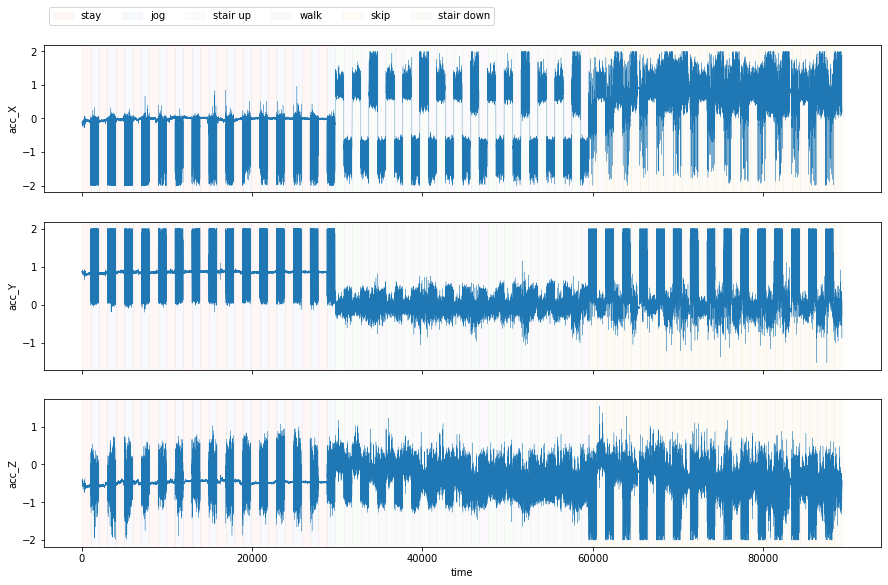

In [38]:
linewidth = 0.3

activities_shown = []
handles = []

fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15, 9))
for i in range(3):
    for s, e, a in zip(idxes_start, idxes_end, activities):
        if a in activities_shown:
            axes[i].axvspan(s, e, color=label2col[a], alpha=0.1, zorder=1)
        else:
            ax = axes[i].axvspan(s, e, color=label2col[a], alpha=0.1, zorder=1, label=a)
            activities_shown.append(a)
            handles.append(ax)
            
axes[0].plot(df.loc[:, 'acc_X'].values, linewidth=linewidth)
axes[0].set_ylabel('acc_X')

axes[1].plot(df.loc[:, 'acc_Y'].values, linewidth=linewidth)
axes[1].set_ylabel('acc_Y')

axes[2].plot(df.loc[:, 'acc_Z'].values, linewidth=linewidth)
axes[2].set_ylabel('acc_Z')
axes[2].set_xlabel('time')

kw = dict(ncol=len(handles), loc="lower left")
plt.legend(handles=handles,
           labels=activities_shown,
           bbox_to_anchor=[0.00, 3.5], 
           **kw
)
plt.subplots_adjust(top=0.9)
plt.savefig(os.path.join(outdir, 'plot_' + id + '.eps'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'plot_' + id + '.png'), bbox_inches='tight')

## SMDL

In [39]:
X = df.dropna().values

In [40]:
h = 900
T = X.shape[0]

In [41]:
norm = Norm()

In [42]:
scores_smdl = np.array([np.nan] * h + 
                 [norm.calc_change_score(X[(i-h):(i+h), :], h, mu_max=50.0, sigma_min=0.005) \
                  for i in tqdm.tqdm(range(h, T-h)) ] + 
                 [np.nan] * h)

100%|██████████| 87524/87524 [04:39<00:00, 312.59it/s]


In [43]:
threshold = 0.75
change_points = detect_change_points_maxscore(scores_smdl - threshold)

/Users/sfukushima/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [44]:
interval = pd.DataFrame({
             'duration': idxes_end - idxes_start +1, 
             'label': activities})

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


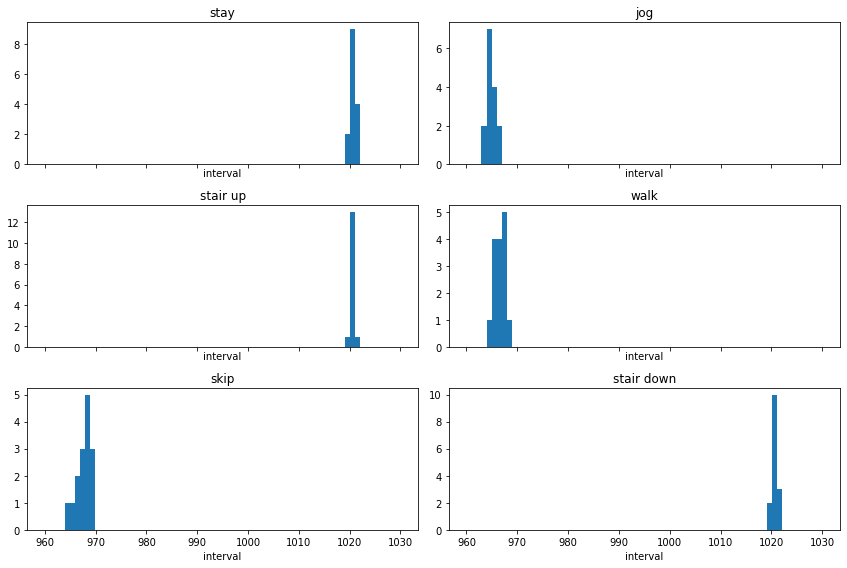

In [45]:
xlim = (960, 1030)

fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12, 8))
axes[0, 0].hist(interval.loc[interval['label']=='stay', 'duration'].values, range=xlim, bins=71)
axes[0, 0].set_title('stay')
axes[0, 0].set_xlabel('interval')

axes[0, 1].hist(interval.loc[interval['label']=='jog', 'duration'].values, range=xlim, bins=71)
axes[0, 1].set_title('jog')
axes[0, 1].set_xlabel('interval')

axes[1, 0].hist(interval.loc[interval['label']=='stair up', 'duration'].values, range=xlim, bins=71)
axes[1, 0].set_title('stair up')
axes[1, 0].set_xlabel('interval')

axes[1, 1].hist(interval.loc[interval['label']=='walk', 'duration'].values, range=xlim, bins=71)
axes[1, 1].set_title('walk')
axes[1, 1].set_xlabel('interval')

axes[2, 0].hist(interval.loc[interval['label']=='skip', 'duration'].values, range=xlim, bins=71)
axes[2, 0].set_title('skip')
axes[2, 0].set_xlabel('interval')

axes[2, 1].hist(interval.loc[interval['label']=='stair down', 'duration'].values, range=xlim, bins=71)
axes[2, 1].set_title('stair down')
axes[2, 1].set_xlabel('interval')

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'hist_duration_activity.png'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'hist_duration_activity.eps'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'hist_duration_activity.pdf'), bbox_inches='tight')

In [46]:
mcas = calc_metachange_stats_v2(X, change_points, h=900)

In [47]:
r = 0.1
change_points_diff_smdl = np.diff(change_points)
lambdas_hat = np.array(
    [(1 - (1-r)**(i+1)) / \
     (r * np.sum( (1-r)**np.arange(i, -1, -1) * change_points_diff_smdl[:i+1] )) \
     for i in range(len(change_points_diff_smdl))]
)
mcat_r01 = -np.log(lambdas_hat) + lambdas_hat * change_points_diff_smdl

In [48]:
r = 0.2
lambdas_hat = np.array(
    [(1 - (1-r)**(i+1)) / \
     (r * np.sum( (1-r)**np.arange(i, -1, -1) * change_points_diff_smdl[:i+1] )) \
     for i in range(len(change_points_diff_smdl))]
)
mcat_r02 = -np.log(lambdas_hat) + lambdas_hat * change_points_diff_smdl

In [49]:
r = 0.3
lambdas_hat = np.array(
    [(1 - (1-r)**(i+1)) / \
     (r * np.sum( (1-r)**np.arange(i, -1, -1) * change_points_diff_smdl[:i+1] )) \
     for i in range(len(change_points_diff_smdl))]
)
mcat_r03 = -np.log(lambdas_hat) + lambdas_hat * change_points_diff_smdl
#change_rate_codelen_smdl = np.abs(np.diff(codelen_time_smdl) / codelen_time_smdl[:-1])

In [50]:
vdetector_smdl_10 = VolatilityDetector(b=10, r=10)
relvol_smdl_10 = np.array([vdetector_smdl_10.detect(cpd) for cpd in change_points_diff_smdl])

vdetector_smdl_15 = VolatilityDetector(b=15, r=15)
relvol_smdl_15 = np.array([vdetector_smdl_15.detect(cpd) for cpd in change_points_diff_smdl])

vdetector_smdl_20 = VolatilityDetector(b=20, r=20)
relvol_smdl_20 = np.array([vdetector_smdl_20.detect(cpd) for cpd in change_points_diff_smdl])

In [51]:
change_points_diff_smdl

array([ 962, 1014,  996,  992,  965, 1021,  963, 1021,  962, 1020,  963,
       1021,  964,  900, 1085, 1019, 1020,  965,  974, 1009,  964, 1010,
        972, 1020,  965, 1020,  963, 1019,  964, 1020,  965, 1020,  966,
       1020,  966, 1020,  966, 1019,  964, 1020,  966, 1020,  965, 1020,
        967, 1020,  965, 1020,  965, 1021,  966, 1020,  964, 1020,  964,
       1020,  964, 1020,  963,  967, 1020,  968, 1019,  968, 1020,  967,
       1020,  963, 1018,  971, 1020,  972, 1015,  966, 1020,  965, 1020,
        969, 1017,  967, 1019,  966, 1021,  967, 1020,  965, 1020,  964])

In [52]:
relvol_smdl_10

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 3.54161404,
       3.18573198, 3.07015695, 3.04376665, 0.87118615, 0.24757194,
       0.25048146, 0.24188937, 0.41345682, 0.47274252, 0.58860786,
       0.51043458, 0.58800538, 0.55981789, 0.63740343, 1.10926968,
       1.26995923, 1.1226644 , 1.47293855, 1.14206369, 1.09826264,
       0.96939354, 1.09581544, 0.9909372 , 1.13566837, 1.1408947 ,
       1.46195004, 1.14932323, 1.60496245, 1.17852366, 1.53940958,
       1.18732883, 1.18732883, 1.18203414, 1.18203414, 1.07580302,
       1.08258472, 1.04429798, 1.04429798, 1.04463144, 0.96577607,
       1.06204019, 0.99923136, 1.02565334, 0.96712694, 0.99017856,
       0.94318569, 0.96171367, 0.91342622, 0.910097  , 0.89093388,
       0.93774491, 0.95511773, 0.93368623, 0.92112247, 0.94898

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

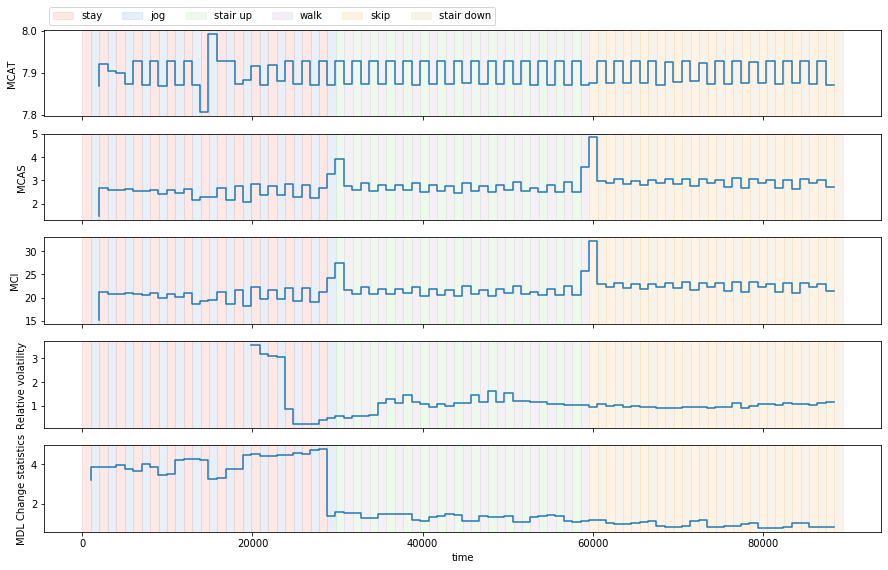

In [53]:
fig, axes = plt.subplots(5, 1, sharex=True, figsize=(15, 9))
activities_shown = []
handles = []

for i in range(5):
    for s, e, a in zip(idxes_start, idxes_end, activities):
        if a in activities_shown:
            axes[i].axvspan(s, e, color=label2col[a], alpha=0.3, zorder=1)
        else:
            ax = axes[i].axvspan(s, e, color=label2col[a], alpha=0.3, zorder=1, label=a)
            activities_shown.append(a)
            handles.append(ax)
            
axes[0].step(change_points[1:], mcat_r01)
axes[0].set_ylabel('MCAT')

axes[1].step(change_points[1:], mcas)
axes[1].set_ylabel('MCAS')

axes[2].step(change_points[1:], mcat_r01 + 5*mcas)
axes[2].set_ylabel('MCI')

axes[3].step(change_points[1:], relvol_smdl_10)
axes[3].set_ylabel('Relative volatility')

axes[4].step(change_points, scores_smdl[change_points])
axes[4].set_xlabel('time')
axes[4].set_ylabel('MDL Change statistics')

kw = dict(ncol=len(handles), loc="lower left") #, frameon=False)
plt.legend(handles=handles,     # The line objects
           labels=activities_shown,   # The labels for each line
           bbox_to_anchor=[0.00, 5.8], 
           **kw
           #title="Legend Title"  # Title for the legend
           )
plt.subplots_adjust(top=0.9)

plt.savefig(os.path.join(outdir, 'result_' + id + '.png'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'result_' + id + '.eps'), bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

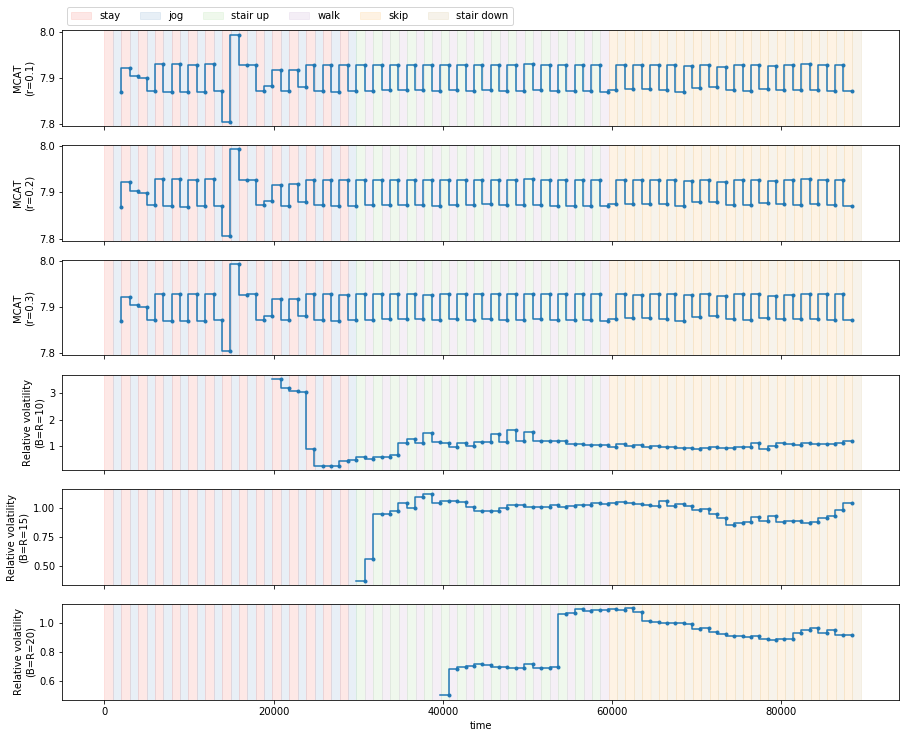

In [54]:
fig, axes = plt.subplots(6, 1, sharex=True, figsize=(15, 12))
for i in range(6):
    for s, e, a in zip(idxes_start, idxes_end, activities):
        if a in activities_shown:
            axes[i].axvspan(s, e, color=label2col[a], alpha=0.3, zorder=1)
        else:
            ax = axes[i].axvspan(s, e, color=label2col[a], alpha=0.3, zorder=1, label=a)
            activities_shown.append(a)
            handles.append(ax)

axes[0].step(change_points[1:], mcat_r01,
             marker='o', markersize=3)
axes[0].set_ylabel('MCAT\n(r=0.1)')

axes[1].step(change_points[1:], mcat_r02, 
             marker='o', markersize=3)
axes[1].set_ylabel('MCAT\n(r=0.2)')

axes[2].step(change_points[1:], mcat_r03, 
             marker='o', markersize=3)
axes[2].set_ylabel('MCAT\n(r=0.3)')

axes[3].step(change_points[1:], relvol_smdl_10, 
             marker='o', markersize=3)
axes[3].set_ylabel('Relative volatility\n(B=R=10)')

axes[4].step(change_points[1:], relvol_smdl_15, 
             marker='o', markersize=3)
axes[4].set_ylabel('Relative volatility\n(B=R=15)')

axes[5].step(change_points[1:], relvol_smdl_20, 
             marker='o', markersize=3)
axes[5].set_xlabel('time')
axes[5].set_ylabel('Relative volatility\n(B=R=20)')

kw = dict(ncol=len(handles), loc="lower left")
plt.legend(handles=handles,
           labels=activities_shown,
           bbox_to_anchor=[0.00, 7], 
           **kw
)
plt.subplots_adjust(top=0.9)

plt.savefig(os.path.join(outdir, 'result_mcat_person06023_all.eps'),
            bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'result_mcat_person06023_all.png'),
            bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

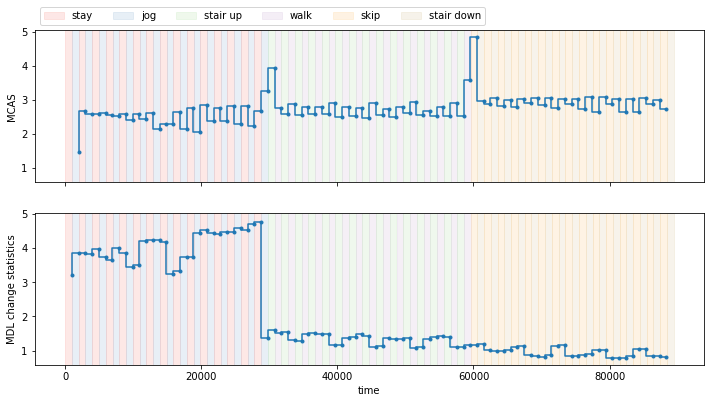

In [55]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(12, 6))
        
axes[0].step(change_points[1:], mcas,
             marker='o', markersize=3)
axes[0].set_ylabel('MCAS')

axes[1].step(change_points, scores_smdl[change_points], 
             marker='o', markersize=3)
axes[1].set_xlabel('time')
axes[1].set_ylabel('MDL change statistics')

activities_shown = []
handles = []

for i in range(2):
    for s, e, a in zip(idxes_start, idxes_end, activities):
        if a in activities_shown:
            axes[i].axvspan(s, e, color=label2col[a], alpha=0.3, zorder=1)
        else:
            ax = axes[i].axvspan(s, e, color=label2col[a], alpha=0.3, zorder=1, label=a)
            activities_shown.append(a)
            handles.append(ax)

kw = dict(ncol=len(handles), loc="lower left")
plt.legend(handles=handles,
           labels=activities_shown,
           bbox_to_anchor=[0.00, 2.2], 
           **kw
)
plt.subplots_adjust(top=0.9)

plt.savefig(os.path.join(outdir, 'result_mcas_' + id + '.eps'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'result_mcas_' + id + '.pdf'), bbox_inches='tight')
plt.savefig(os.path.join(outdir, 'result_mcas_' + id + '.png'), bbox_inches='tight')